In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy.fftpack import fft
import time
import seaborn as sns

class MelSpectrogramGenerator:
    def __init__(self):
        """ Initialize the Mel filter bank parameters.
                Args:
                    sample_rate (int): The sample rate of the audio signal. Default is 22050.
                    n_fft (int): The number of FFT components. Default is 2048.
                    hop_length (int): The number of samples between successive frames. Default is 512.
                    n_mels (int): The number of Mel bands to generate. Default is 80.
                    fmin (float): The lowest frequency (in Hz). Default is 0.
                    fmax (float): The highest frequency (in Hz). If None, it will be set to sample_rate // 2. Default is None.
                    power (float): The power to raise the magnitude spectrogram. Default is 2.0.
                """
        self.sr = DEFAULTS['sample_rate']
        self.n_fft = DEFAULTS['n_fft']
        self.hop_length =  DEFAULTS['hop_length']
        self.n_mels = DEFAULTS['n_mels']
        self.fmin = DEFAULTS['fmin']
        self.fmax = DEFAULTS['fmax'] if DEFAULTS['fmax'] else self.sr // 2
        DEFAULTS['fmax'] = self.fmax
        self.power = DEFAULTS['power']
        
        # Pre-compute mel filter bank
        self.mel_basis = self._create_mel_filter_bank()
        
    def hz_to_mel(self, hz):
        """Convert Hz to Mel scale."""
        return 2595 * np.log10(1 + hz / 700)
    
    def mel_to_hz(self, mel):
        """Convert Mel scale to Hz."""
        return 700 * (10 ** (mel / 2595) - 1)
    
    def _create_mel_filter_bank(self):
        """Create mel filter bank matrix."""
        # Convert min and max frequencies to mel scale
        mel_min = self.hz_to_mel(self.fmin)
        mel_max = self.hz_to_mel(self.fmax)
        
        # Create evenly spaced points in mel scale
        mel_points = np.linspace(mel_min, mel_max, self.n_mels + 2)
        hz_points = self.mel_to_hz(mel_points)

        # For n_fft bins of x, there are (x+1)/2 bins representing frequencies from 0 to nyquist frequency (sr // 2)
        # This is a mapping from hz_points to FFT bin numbers
        bins = np.floor((self.n_fft + 1) * hz_points / self.sr).astype(int)
        
        # Create the filter bank matrix
        # Note: bins are in the range [0, n_fft // 2 + 1] as the result of FFT is symmetric
        # This filter bank is going to be multiplied by spectrogram of shape (n_fft // 2 + 1, n_frames)
        fbank = np.zeros((self.n_mels, self.n_fft // 2 + 1))
        # Iterate over each mel frequency
        # For each mel frequency, the filter bank is a triangle filter centered at that frequency
        # The filter bank is linearly interpolated between the two adjacent FFT bins
        # Let's say we have a mel frequency at bin i, then the filter bank is a triangle filter centered at i with height 1 and 0 at i-1 and i+1 (if they exist)
        for i in range(self.n_mels):
            for j in range(bins[i], bins[i + 2]):
                if j < len(fbank[0]):
                    if j < bins[i + 1]:
                        fbank[i, j] = (j - bins[i]) / (bins[i + 1] - bins[i])
                    else:
                        fbank[i, j] = (bins[i + 2] - j) / (bins[i + 2] - bins[i + 1])
        
        return fbank # Which is also called mel_basis
    
    def compute_stft(self, audio):
        """Compute Short-Time Fourier Transform."""

        return librosa.stft(audio, n_fft=self.n_fft, 
                       hop_length=self.hop_length,
                       window='hann').T
    
    def generate(self, audio):
        """Generate mel spectrogram from audio signal."""
        # Compute STFT
        stft_matrix = self.compute_stft(audio)
        
        # Convert to power spectrogram
        power_spec = np.abs(stft_matrix) ** self.power
        
        # Apply mel filter bank
        mel_spec = np.dot(power_spec, self.mel_basis.T)
        
        # Convert to log scale
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        print(f"STFT shape: {stft_matrix.shape}")
        print(f"Power spec shape: {power_spec.shape}")
        print(f"Mel filter shape: {self.mel_basis.shape}")
        print(f"Final mel shape: {mel_spec.shape}")
        
        return {
            'stft': stft_matrix,
            'power_spec': power_spec,
            # Transpose to match librosa's output
            'mel_spec': mel_spec.T,
            'mel_spec_db': mel_spec_db.T
        }

def analyze_and_visualize(audio_path):
    """Analyze audio file and compare custom implementation with librosa."""

    # Use same parameters for both implementations
    n_fft = DEFAULTS['n_fft']
    hop_length = DEFAULTS['hop_length']
    n_mels = DEFAULTS['n_mels']
    

    # Load audio file
    audio, sr = librosa.load(audio_path)
    audio = librosa.util.fix_length(audio, size=len(audio) + hop_length)

    fmin = DEFAULTS['fmin']
    fmax = DEFAULTS['fmax']

    # Initialize our custom generator
    custom_mel = MelSpectrogramGenerator()
    
    # Time both implementations
    start_time = time.time()
    custom_results = custom_mel.generate(audio)
    
    custom_time = time.time() - start_time
    
    start_time = time.time()
    librosa_mel = librosa.feature.melspectrogram(y=audio, sr=sr, 
                                                n_fft=n_fft,
                                                hop_length=hop_length,
                                                n_mels=n_mels,
                                                fmin=fmin,
                                                fmax=fmax)
    
    librosa_mel_db = librosa.power_to_db(librosa_mel, ref=np.max)
    librosa_time = time.time() - start_time

    print(f"Audio length: {len(audio)}")
    print(f"Custom mel shape: {custom_results['mel_spec_db'].shape}")
    print(f"Librosa mel shape: {librosa_mel.shape}")
    
    # Create visualization
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Raw waveform
    plt.subplot(3, 2, 1)
    plt.title('Raw Waveform')
    plt.plot(audio)
    plt.grid(True)
    
    # Plot 2: STFT magnitude
    plt.subplot(3, 2, 2)
    plt.title('STFT Magnitude')
    plt.imshow(np.log1p(np.abs(custom_results['stft'])), 
              aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    
    # Plot 3: Mel Filter Bank
    plt.subplot(3, 2, 3)
    plt.title('Mel Filter Bank')
    plt.imshow(custom_mel.mel_basis, aspect='auto', origin='lower')
    plt.colorbar()
    
    # Plot 4: Custom Mel Spectrogram
    plt.subplot(3, 2, 4)
    plt.title('Custom Mel Spectrogram')
    plt.imshow(custom_results['mel_spec_db'], 
              aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    
    # Plot 5: Librosa Mel Spectrogram
    plt.subplot(3, 2, 5)
    plt.title('Librosa Mel Spectrogram')
    plt.imshow(librosa_mel_db, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    
    # Plot 6: Difference between implementations
    plt.subplot(3, 2, 6)
    diff = custom_results['mel_spec_db'] - librosa_mel_db
    plt.title('Difference (Custom - Librosa)')
    plt.imshow(diff, aspect='auto', origin='lower', cmap='RdBu')
    plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    
    # Print analysis results
    print(f"Processing Times:")
    print(f"Custom Implementation: {custom_time:.3f} seconds")
    print(f"Librosa Implementation: {librosa_time:.3f} seconds")
    
    print("\nShape Comparison:")
    print(f"Custom Mel Spectrogram Shape: {custom_results['mel_spec_db'].shape}")
    print(f"Librosa Mel Spectrogram Shape: {librosa_mel_db.shape}")
    
    print("\nValue Range Comparison:")
    print(f"Custom Mel Spectrogram Range: [{custom_results['mel_spec_db'].min():.2f}, {custom_results['mel_spec_db'].max():.2f}]")
    print(f"Librosa Mel Spectrogram Range: [{librosa_mel_db.min():.2f}, {librosa_mel_db.max():.2f}]")
    
    print("\nDifference Statistics:")
    print(f"Mean Absolute Difference: {np.abs(diff).mean():.4f}")
    print(f"Max Absolute Difference: {np.abs(diff).max():.4f}")
    print(f"Standard Deviation of Difference: {diff.std():.4f}")
    
    return custom_results, librosa_mel_db



In [104]:
DEFAULTS = {
    'sample_rate': 16000,
    'n_fft': 2048,
    'hop_length': 512, 
    'n_mels': 80,
    'fmin': 0,
    'fmax': None,
    'power': 2.0
}

STFT shape: (90, 1025)
Power spec shape: (90, 1025)
Mel filter shape: (80, 1025)
Final mel shape: (90, 80)
Audio length: 45749
Custom mel shape: (80, 90)
Librosa mel shape: (80, 90)
Processing Times:
Custom Implementation: 0.151 seconds
Librosa Implementation: 0.006 seconds

Shape Comparison:
Custom Mel Spectrogram Shape: (80, 90)
Librosa Mel Spectrogram Shape: (80, 90)

Value Range Comparison:
Custom Mel Spectrogram Range: [-80.00, 0.00]
Librosa Mel Spectrogram Range: [-80.00, 0.00]

Difference Statistics:
Mean Absolute Difference: 5.9177
Max Absolute Difference: 48.7916
Standard Deviation of Difference: 7.7598


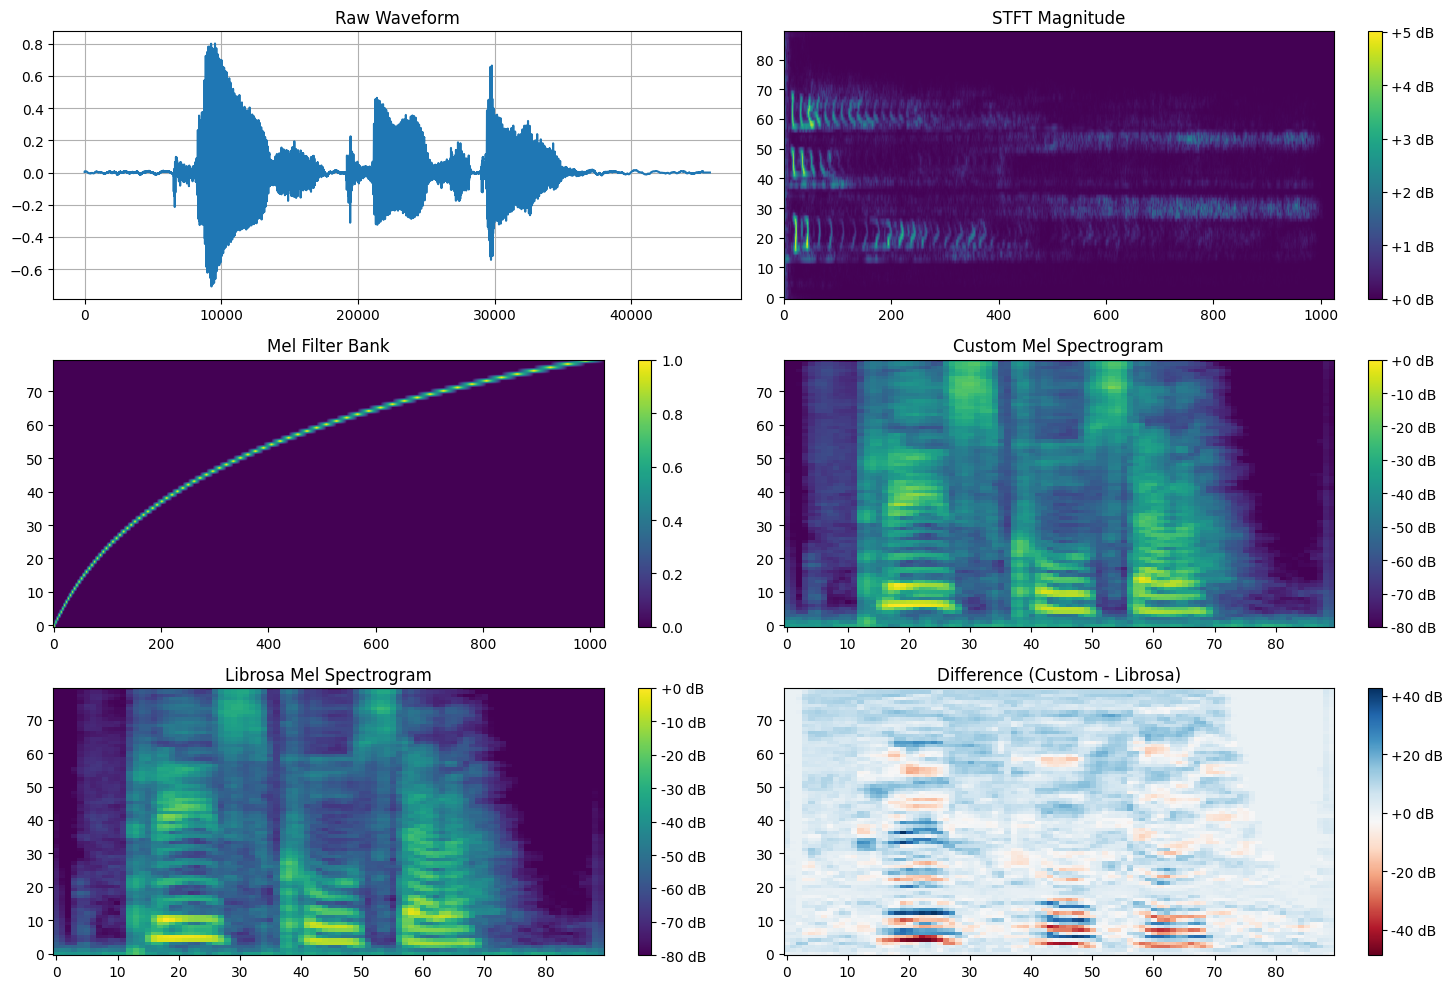

In [105]:
audio_path = "p225_001_mic1.flac"
custom_results, librosa_results = analyze_and_visualize(audio_path)